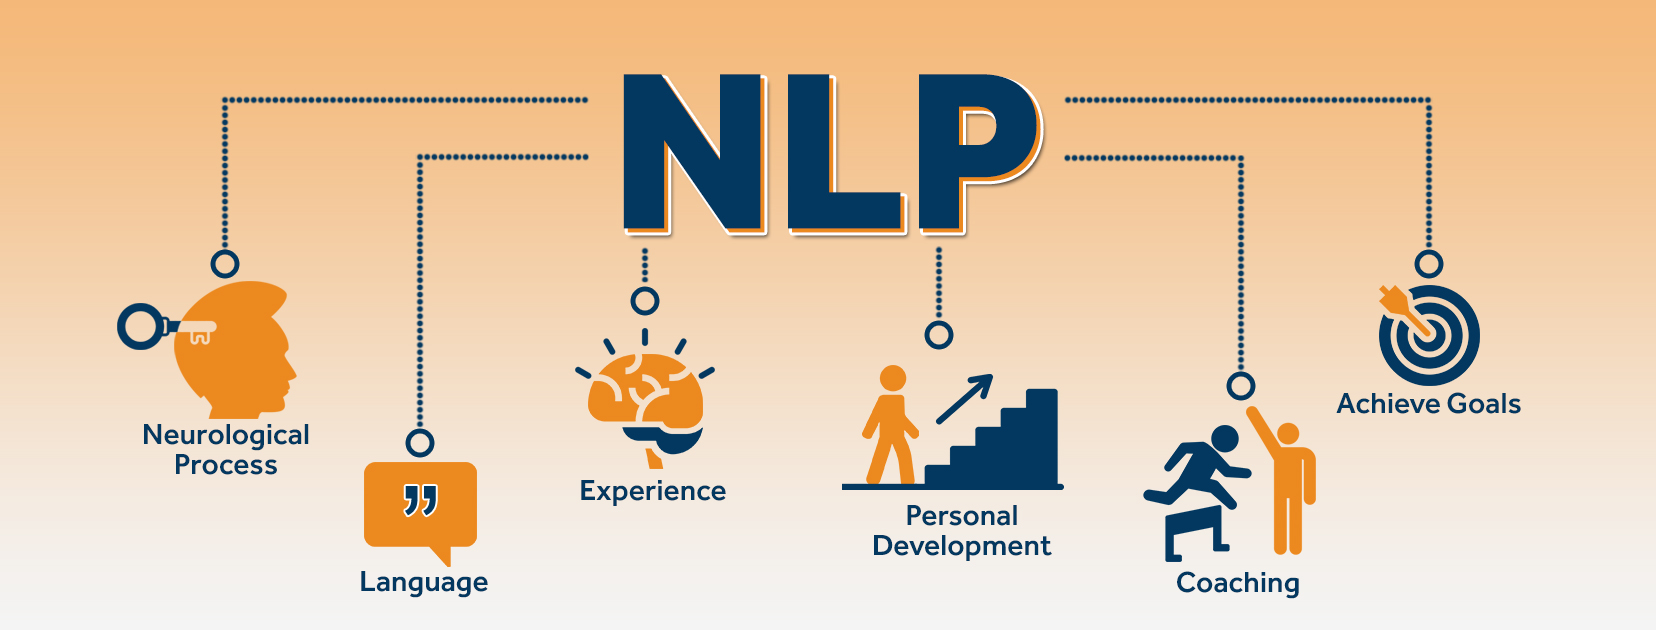




Natural Language Processing, or NLP for short, is broadly defined as the automatic manipulation of natural language, like speech and text, by software.

The study of natural language processing has been around for more than 50 years and grew out of the field of linguistics with the rise of computers.

**In this NoteBook, I will discover natural language processing of Disaster Tweets**

**Description of competitions dataset**

* id - a unique identifier for each tweet

* text - the text of the tweet

* location - the location the tweet was sent from (may be blank)

* keyword - a particular keyword from the tweet (may be blank)

* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import  PorterStemmer
import string
special = string.punctuation


## Load Data

In [ ]:
train=pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
train.head()

 Analysis The Dataset

In [ ]:
train.info()

In [ ]:
train.isnull().sum()

*In train dataset , 61 null values in keyword column and 2533 null values in location column*

In [ ]:
mis_val_col=['keyword','location']
missing_x=train[mis_val_col].isnull().sum().index
missing_y=train[mis_val_col].isnull().sum().values
plt.bar(missing_x, missing_y)
plt.title('Total Missing value')
plt.ylabel('Null Value range')
plt.show()

In [ ]:
tar_1=len(train[train['target'].values==1])
tar_2=len(train[train['target'].values==0])
print(tar_2)

In [ ]:
plt.pie([tar_1,tar_2], labels=['1','0'])
plt.title('Target distribution')
plt.show()

In [ ]:
disaster_1=train[train['target']==1]['text'].str.len()
disaster_0=train[train['target']==0]['text'].str.len()

In [ ]:
plt.subplot(1,1,1)
plt.hist(disaster_1,bins=60)
plt.title('Posative disaster tweets')
plt.show()
plt.subplot(1,2,1)
plt.hist(disaster_0,bins=20)
plt.title('No disaster tweets')
plt.show()

## Number of words in per tweets

In [ ]:
no_disaster=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
yes_disaster=train[train['target']==1]['text'].str.split().map(lambda x: len(x))

In [ ]:
plt.subplot(1,1,1)
sns.lineplot(x=no_disaster.index,y=no_disaster,)
plt.title('No disaster texr len')
plt.xlabel('Index')
plt.ylabel('Text length')
plt.show()

plt.subplot(2,1,1)
sns.lineplot(x=yes_disaster.index,y=yes_disaster,)
plt.title('Yes disaster texr len')
plt.xlabel('Index')
plt.ylabel('Text length')
plt.show()

## Define feature column and target column


In [ ]:
feature=train['text'].copy()
target=train['target'].copy()
print(feature.shape)
print(target.shape)

## NLP operation

In [ ]:
nltk.download('stopwords')

In [ ]:
ps=PorterStemmer()
word_list=[]

In [ ]:
for i in range(len(feature)):
  review=re.sub('^a-zA-Z',' ',feature[i])
  review=re.sub(r'[^\w\s]', '', review) #remove puntuation
  review=re.sub(r'[0-9]+', '', review) #remove Number
  review=review.lower()
  review=review.split()
  review=[ps.stem(word) for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  word_list.append(review)

In [ ]:
word_list[1:5]

print(len(word_list))

In **natural language processing**, a one-hot vector is a 1 × N matrix (vector) used to distinguish each word in a vocabulary from every other word in the vocabulary. The vector consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify the word. One-hot encoding ensures that machine learning does not assume that higher numbers are more important. For example, the value '8' is bigger than the value '1', but that does not make '8' more important than '1'. The same is true for words: the value 'laughter' is not more important than 'laugh'.

In [ ]:
vc_size=7000 #define number of vocab size


word_list_onhot=[one_hot(word,vc_size) for word in word_list]
word_list_onhot[1]

# *Find max len*

In [ ]:
sentence_len=[]
for i in range(len(word_list_onhot)):
  x=len(word_list_onhot[i])
  sentence_len.append(x)

In [ ]:
# x='dfsdf'
len(word_list)

## **Padding**

In [ ]:
print(type(sentence_len))
sen_len=max(sentence_len)
print('Max length of a line is :',sen_len)

In [ ]:
word_embeding=pad_sequences(word_list_onhot,padding='pre',maxlen=sen_len)
word_embeding.shape

## Create Model

In [ ]:
model=Sequential()
model.add(Embedding(vc_size,25,input_length=sen_len))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
type(word_embeding)

In [ ]:
target=np.array(target)
type(target)

# Split train and test data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(word_embeding, target, test_size=0.5, random_state=101)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Fit the model

In [ ]:
model_hist=model.fit(word_embeding,target, validation_data=(X_test,y_test),epochs=10,batch_size=32,)

### Now its time to Prediction 

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
# pred=model.predict_classes(X_test)
pred = model.predict(X_test)
pred = np.round(pred).astype(int)

In [ ]:
confusion_matrix(y_test,pred)

In [ ]:
accuracy_score(y_test,pred)*100

**My model provide around 97% accuracy. Thats prety good **



In [ ]:
# save model
model.save('NLP_for_Disaster_Tweets.h5')

## Load model

In [ ]:
 from tensorflow.keras.models import load_model

In [ ]:
model=load_model("NLP_for_Disaster_Tweets.h5")

## Prepare Test dataset

In [ ]:
test.head()

In [ ]:
test_feature=test['text']


In [ ]:
test_word_list=[]
for i in range(len(test_feature)):
  review=re.sub('^a-zA-Z',' ',test_feature[i])
  review=re.sub(r'[^\w\s]', '', review) #remove puntuation
  review=re.sub(r'[0-9]+', '', review) #remove Number
  review=review.lower()
  review=review.split()
  review=[ps.stem(word) for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  test_word_list.append(review)

In [ ]:
test_word_list[0:5]

In [ ]:
test_word_list_onhot=[one_hot(word,vc_size) for word in test_word_list]

In [ ]:
sentence_len=[]
for i in range(len(test_word_list_onhot)):
  x=len(word_list_onhot[i])
  sentence_len.append(x)
print(type(sentence_len))
sen_len=max(sentence_len)
print('Max length of a line is :',sen_len)

In [ ]:
test_word_embeding=pad_sequences(test_word_list_onhot,padding='pre',maxlen=sen_len)
test_word_embeding.shape

In [ ]:
test_pred=model.predict(test_word_embeding)

In [ ]:
test_pred.shape

In [ ]:
x=test_pred[2][0]

In [ ]:
type(x)

In [ ]:
test_prediction=test_pred.copy()

In [ ]:
# final_target=[]
for i in range(len(test_prediction)):
  if test_prediction[i][0]>=0.6:
    test_prediction[i]=1
  # print(test_pred[i])
  else:
    test_prediction[i]=0

In [ ]:
test_pred[0][0]

# Prepare Submission file

In [ ]:
target_id=(test['id'])
final_target=test_prediction

In [ ]:
submission_df=pd.DataFrame(columns=['id','target'])

In [ ]:
submission_df

In [ ]:
submission_df['id']=target_id
submission_df['target']=final_target.astype(int)

In [ ]:
submission_df

In [ ]:
print('Total posative disaster in test dataset :',len(submission_df[submission_df['target']==1]))
print('Total Negative disaster in test dataset :',len(submission_df[submission_df['target']==0]))



In [ ]:
submission_df.to_csv('submission.csv',index=False)